# Lab Session 1: Environment setup and feedforward networks in PyTorch

#### Lab setup instructions

We recommend that you work on the Ubuntu workstations in the lab. We cannot guarantee compatibility with Windows machines and cannot promise support if you choose to work on a Windows machine.

Once logged in, run the following commands in the terminal to set up a Python environment with all the packages you will need.

    export PYTHONUSERBASE=/vol/bitbucket/nuric/pypi
    export PATH=/vol/bitbucket/nuric/pypi/bin:$PATH

Add the above lines to your `.bashrc` to have these enviroment variables set automatically each time you open your bash terminal.

Run `jupyter-notebook` in the directory in which you've cloned the tutorial repo to launch Jupyter notebook in your default browser.

This may take a while to run the first time while the packages are cached on your local machine.

DO NOT attempt to create a virtualenv in your home folder as you will likely exceed your file quota.

#### Google Colaboratory

Alternatively, you can use Google Colaboratory, which provides free GPU time.

You will need a Google account to do so. Simply log in to your account and go to the following page: https://colab.research.google.com

You will need to install a few packages only if you choose to use Colab. Run the following command in a Colab notebook cell to install pytorch:

    !pip install torch torchvision

#### Instructions

Your task is to replicate what was shown in the demonstration: use PyTorch to implement a one-hidden layer neural network to classify MNIST digits.

HINT: you may find the following imports useful:

    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torch.utils.data import DataLoader
    from torchvision import datasets, transforms
    
Try to consult the PyTorch documentation if you get stuck. We will also be available in the lab to answer questions.

Experiment with different hyperparameter settings and optimizers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Setting a seed to ensure results are reproducible
torch.manual_seed(0)

# Defining a model

In [3]:
class OneHiddenLayerMNISTClassifier(nn.Module):
    
    def __init__(self, n_hidden_layers=32, IN_FEATURES=784, OUT_FEATURES=10):
        super().__init__()
        self.IN_FEATURES = IN_FEATURES
        self.OUT_FEATURES = OUT_FEATURES
        self.linear1 = nn.Linear(
            in_features=self.IN_FEATURES, out_features=n_hidden_layers, bias=True
        )
        self.linear2 = nn.Linear(
            in_features=n_hidden_layers, out_features=self.OUT_FEATURES, bias=True
        )
        
    def forward(self, data):
        data = self.linear1(data.view(-1, self.IN_FEATURES))
        data = F.relu(data)
        data = self.linear2(data)
        return F.log_softmax(data, dim=1)

In [4]:
def train(model, train_loader, optimizer, epoch, log_interval=100):
    """
    A utility function that performs a basic training loop.

    For each batch in the training set, fetched using `train_loader`:
        - Zeroes the gradient used by `optimizer`
        - Performs forward pass through `model` on the given batch
        - Computes loss on batch
        - Performs backward pass
        - `optimizer` updates model parameters using computed gradient

    Prints the training loss on the current batch every `log_interval` batches.
    """
    for batch_index, (inputs, labels) in enumerate(train_loader):
        # Set previously computed gradients to zero, i.e. do not accumulate
        optimizer.zero_grad()
        # Get predictions
        outputs = model(inputs)
        # Calculate negative log likelihood loss
        loss = F.nll_loss(outputs, labels)
        # Propagate the errors, i.e. compute the new gradients
        loss.backward()
        # Update the parameters using the new gradients
        optimizer.step()
        
        if batch_index % log_interval == 0:
            print(
                "Train Epoch: {:02d} -- Batch: {:03d} -- Loss: {:.4f}".format(
                    epoch,
                    batch_index,
                    # Calling `loss.item()` returns the scalar loss as a Python
                    # number.
                    loss.item(),
                )
            )

In [5]:
def test(model, test_loader):
    """
    A utility function to compute the loss and accuracy on a test set by
    iterating through the test set using the provided `test_loader` and
    accumulating the loss and accuracy on each batch.
    """
    test_loss = 0.
    correct_predictions = 0.
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Make the predictions
            outputs = model(inputs)
            # Compute the sum of losses
            test_loss += F.nll_loss(outputs, labels, reduction="sum").item()
            # Get predictions with highest probabilities
            predictions = outputs.argmax(dim=1, keepdim=True)
            # Sum the correct predictions
            correct_predictions += predictions.eq(labels.view_as(predictions)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    correct_predictions /= len(test_loader.dataset)
    
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n".format(
            test_loss, correct_predictions
        )
    )

# Fetching Data

tensor(5)
torch.Size([1, 28, 28])
torch.Size([28, 28])


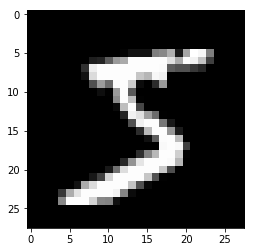

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor()]#, transforms.Normalize((0.1307,), (0.3081,))]
)

train_data = datasets.MNIST(
    "train_data/", train=True, download=True, transform=transform
)

test_data = datasets.MNIST(
    "test_data/", train=False, download=True, transform=transform
)

sample_data, sample_label = train_data[0]

print(sample_label)
print(sample_data.size())
print(sample_data.squeeze().size())

plt.imshow(sample_data.squeeze(), cmap='gray')

# DataLoader

In [7]:
# DataLoader is good for iterating over shuffled data

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=False)

sample_inputs, sample_targets = next(iter(train_loader))

print(sample_inputs.shape, sample_targets.shape, '\n')
print(sample_targets)

torch.Size([64, 1, 28, 28]) torch.Size([64]) 

tensor([5, 6, 5, 8, 9, 3, 8, 0, 5, 4, 1, 5, 1, 3, 2, 2, 7, 6, 4, 0, 3, 8, 5, 6,
        6, 2, 1, 1, 8, 3, 1, 0, 7, 1, 3, 3, 2, 7, 3, 2, 3, 3, 2, 0, 5, 3, 7, 5,
        2, 3, 9, 7, 5, 2, 2, 8, 7, 3, 6, 1, 1, 7, 2, 1])


# Training the model

In [8]:
# Instance of a model
model = OneHiddenLayerMNISTClassifier()

# Instance of optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Train-test loop
for epoch in range(7):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 00 -- Batch: 000 -- Loss: 2.3109
Train Epoch: 00 -- Batch: 100 -- Loss: 0.8254
Train Epoch: 00 -- Batch: 200 -- Loss: 0.3472
Train Epoch: 00 -- Batch: 300 -- Loss: 0.4184
Train Epoch: 00 -- Batch: 400 -- Loss: 0.3117
Train Epoch: 00 -- Batch: 500 -- Loss: 0.3917
Train Epoch: 00 -- Batch: 600 -- Loss: 0.2079
Train Epoch: 00 -- Batch: 700 -- Loss: 0.2580
Train Epoch: 00 -- Batch: 800 -- Loss: 0.2118
Train Epoch: 00 -- Batch: 900 -- Loss: 0.2659

Test set: Average loss: 0.2515, Accuracy: 0.9264

Train Epoch: 01 -- Batch: 000 -- Loss: 0.1736
Train Epoch: 01 -- Batch: 100 -- Loss: 0.3511
Train Epoch: 01 -- Batch: 200 -- Loss: 0.1825
Train Epoch: 01 -- Batch: 300 -- Loss: 0.3883
Train Epoch: 01 -- Batch: 400 -- Loss: 0.2972
Train Epoch: 01 -- Batch: 500 -- Loss: 0.2620
Train Epoch: 01 -- Batch: 600 -- Loss: 0.2584
Train Epoch: 01 -- Batch: 700 -- Loss: 0.2006
Train Epoch: 01 -- Batch: 800 -- Loss: 0.2944
Train Epoch: 01 -- Batch: 900 -- Loss: 0.4673

Test set: Average loss: 0.19

In [9]:
# Save weights
torch.save(model.state_dict(), "mnist_custom_model.pt")

# Load weights
model.load_state_dict(torch.load("mnist_custom_model.pt"))